In [1]:
import pandas
import os
import itertools
import numpy as np
import nibabel as ni
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection, linear_model
from nilearn import image, plotting
from mpl_toolkits.mplot3d import Axes3D

//anaconda/envs/py3/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import sys
git_dir = '/Users/jakevogel/git/Hippocampus_AP_Axis/'
sys.path.insert(0,git_dir)
import HAP_Utils as hap

//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [5]:
# PERSONAL COMPUTER
wdir = '/Users/jakevogel/Science/AHBA/'
df = pandas.read_csv(os.path.join(wdir,'MAIN_hippocampus_sample_info.csv'))
xp = pandas.read_csv(os.path.join(wdir,'MAIN_hippocampus_gxp.csv'),index_col=0)
gdf = pandas.read_csv(os.path.join(wdir,'MAIN_gcx_wholebrain_info.csv'))
probes = pandas.read_csv('/Users/jakevogel/Downloads/normalized_microarray_donor9861/Probes.csv')

In [6]:
big_tfm = pandas.read_csv('/Users/jakevogel/Science/AHBA/postreject/BIGDF_PCA_tfm.csv', index_col=0)
big_tfm.shape

(3702, 170)

In [7]:
#Load the atlases
ex = ni.load('/Users/jakevogel/Science/tau/dkt_atlas_1mm.nii.gz')
dkt = ni.load('/Users/jakevogel/Science/tau/dkt_atlas_1mm.nii.gz').get_data()
#dkt = ni.load('/home/users/jvogel/Science/templates/atlases/dkt_atlas_1mm.nii.gz').get_data()
#HO = ni.load(
#        '/usr/share/fsl/data/atlases/HarvardOxford/HarvardOxford-sub-maxprob-thr0-1mm.nii.gz'
#            ).get_data()
HO = ni.load(
        '/usr/local/fsl/data/atlases/HarvardOxford/HarvardOxford-sub-maxprob-thr0-1mm.nii.gz'
            ).get_data()

#whole brain
msk1 = np.array(HO,copy=True)
msk1[HO<1] = 0

#no cereb or brainstem
msk2 = np.array(dkt, copy=True)
msk2[msk2>78] = 0
msk2 = np.array(dkt, copy=True)
msk2[msk2>78] = 0

# no cereb, brainstem or hippocampus
msk3 = np.array(msk2, copy=True)
msk3[dkt==36] = 0
msk3[dkt==75] = 0

# cortex only (no subcortex)
msk4 = np.array(msk3, copy=True)
msk4[dkt>31] = 0
msk4[dkt>41] = dkt[dkt>41]
msk4[dkt>70] = 0

In [8]:
func = ni.load('/Users/jakevogel/Science/AHBA/postreject/GA_fmri_img.nii.gz')
msk2_2mm = image.resample_to_img(ni.Nifti1Image(msk2, ex.affine), 
                                 func, interpolation='nearest')

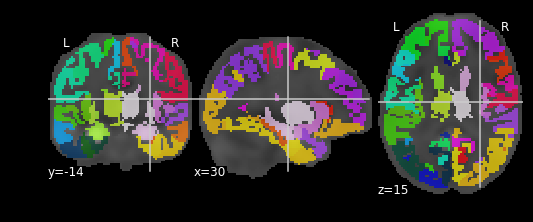

In [9]:
plt.close()
plotting.plot_roi(msk2_2mm,func)
plt.show()

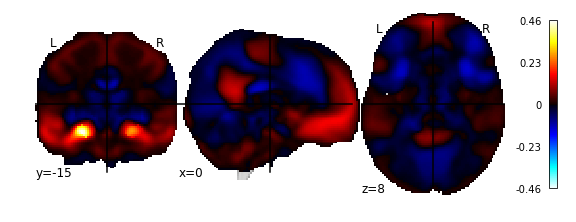

In [9]:
plt.close()
plotting.plot_stat_map(func)
plt.show()

In [10]:
vectors = {}

//anaconda/envs/py3/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


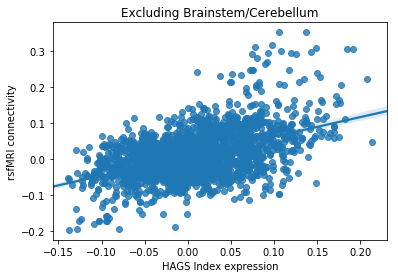

standard statistics: r2 = 0.23338635397761273, p = 5.528952207575947e-125


In [11]:
# functional
img = func.get_data()
vrad=3
vdim = 2
gcx_col='AP_axis_gxp_signature_similarity_SPCR'
bootstrap = False
plabs = ['Excluding Brainstem/Cerebellum',
         'HAGS Index expression','rsfMRI connectivity']
res, vex = hap.run_gvfcx_analysis(img, gdf, msk2_2mm.get_data(), vrad, vdim, gcx_col, plabs, 
                       bootstrap, n_iter=10, hue_vals=[], illustrative=True)
vectors.update({'gcx': vex['g_vector'], 'fcx': vex['cx_vector']})

In [12]:
len(vectors['fcx'])

2130

In [13]:
# find samples falling within mask
gmsk = msk2_2mm.get_data()
gmsk[gmsk>0] = 1
hits = []
for i,row in gdf.iterrows():
    coords = hap.convert_coords([row['mni_nlin_x'], 
                                 row['mni_nlin_y'], 
                                 row['mni_nlin_z']], 
                                'xyz', vs=2)
    coords = tuple([int(round(x)) for x in coords])
    if gmsk[coords] == 1:
        hits.append(i)
    

In [14]:
len(hits)

2130

In [15]:
big_tfm.loc[hits].shape

(2130, 170)

In [17]:
mod_FUNC = hap.PCA_LR_pipeline(big_tfm.loc[hits].values, # X (Gene expression)
                                    vectors['fcx'], # Y (relative cx to a vs. p hipp)
                                    pca = None,
                                    cv_strategy='score', # Show the 10-fold CV score
                                    illustrative=False, # Don't show plots
                                    test_gene_num = [1, 2, 5, 10, 20, 50, 100,  # sanity check
                                                    200, 500, 1000, 2000, 5000],
                                    sanity_check_style = 'model') # post. and ant. separate

performing model cross-validation
using basic 10-fold cross-validation
model cv score: r2 =  0.3420975645018261
running final model
final model fit r2 =  0.4494674994988053
running sanity_check


KeyboardInterrupt: 

In [16]:
big_htfm = pandas.read_csv('/Users/jakevogel/Science/AHBA/postreject/BIGDF_HIPP_tfm.csv', 
                           index_col=0)

In [17]:
mod_hFUNC = hap.PCA_LR_pipeline(big_htfm.loc[hits].values, # X (Gene expression)
                                    vectors['fcx'], # Y (relative cx to a vs. p hipp)
                                    pca = None,
                                    cv_strategy='score', # Show the 10-fold CV score
                                    illustrative=False, # Don't show plots
                                    test_gene_num = [100],
                                    sanity_check_style = 'model') # post. and ant. separate

performing model cross-validation
using basic 10-fold cross-validation
model cv score: r2 =  0.3183506071747872
running final model
final model fit r2 =  0.4737442556877228
running sanity_check


running PCA
transforming data
performing model cross-validation
using basic 10-fold cross-validation


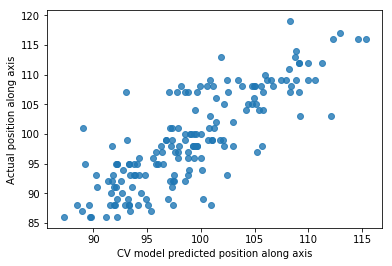

model cv score: r2 =  0.6758859774821814
running final model
final model fit r2 =  0.8768105093258005


//anaconda/envs/py3/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


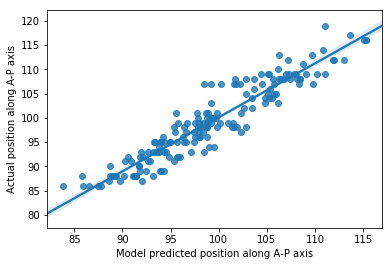

running sanity_check


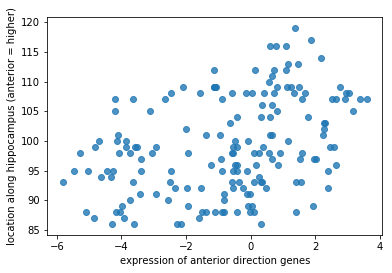

anterior 1 genes vs. y:  r2 = 0.14629196014520224, p = 2.643623001667436e-07 




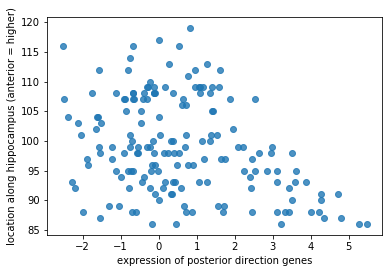

posterior 1 genes vs. y:  r2 = 0.12083902318757654, p = 3.406748231336911e-06 




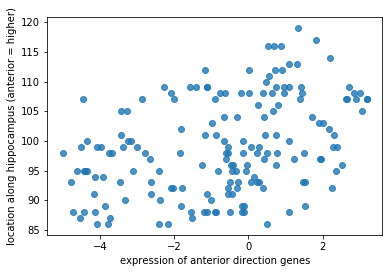

anterior 2 genes vs. y:  r2 = 0.15681046319903055, p = 9.033761155250064e-08 




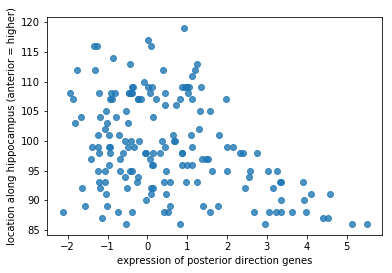

posterior 2 genes vs. y:  r2 = 0.14078245533337322, p = 4.619806057631215e-07 




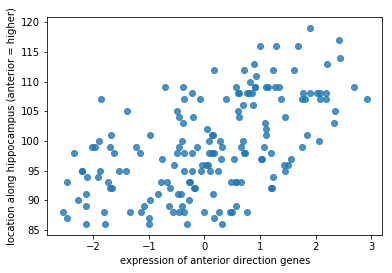

anterior 5 genes vs. y:  r2 = 0.3120276412846879, p = 2.4662826207105336e-15 




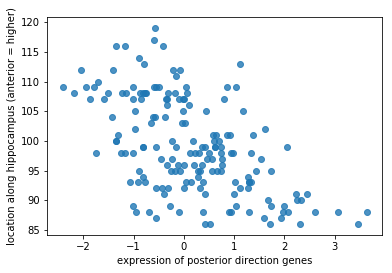

posterior 5 genes vs. y:  r2 = 0.3088720843951695, p = 3.640128882095161e-15 




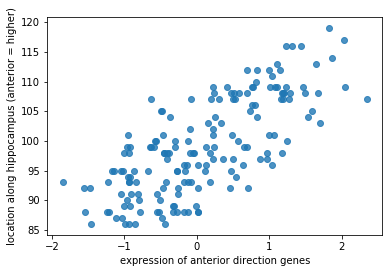

anterior 10 genes vs. y:  r2 = 0.5417433381516534, p = 2.8362558223402614e-30 




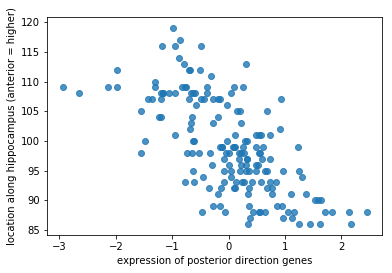

posterior 10 genes vs. y:  r2 = 0.45513306654039, p = 6.3820616343206416e-24 




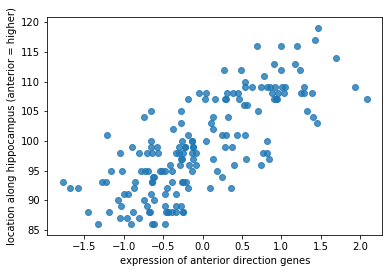

anterior 20 genes vs. y:  r2 = 0.5772779741942704, p = 3.123957404584345e-33 




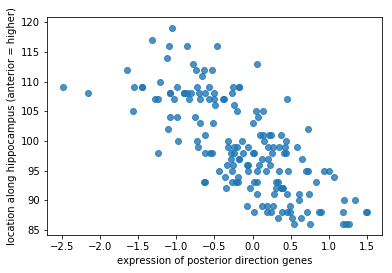

posterior 20 genes vs. y:  r2 = 0.5287595402930862, p = 3.0001152711919667e-29 




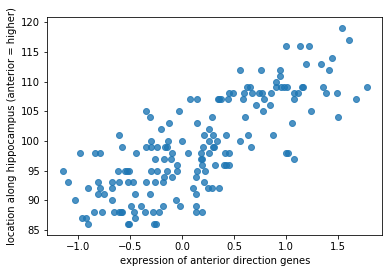

anterior 50 genes vs. y:  r2 = 0.6047815666383575, p = 1.072778633816526e-35 




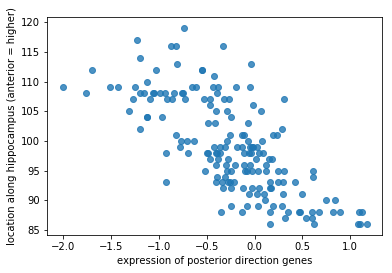

posterior 50 genes vs. y:  r2 = 0.5214958089955475, p = 1.091698561865245e-28 




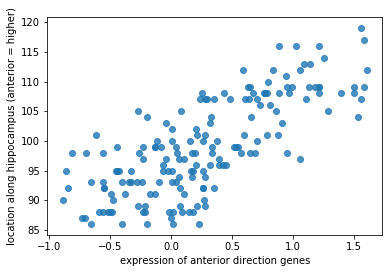

anterior 100 genes vs. y:  r2 = 0.5685353701955165, p = 1.7568686274802046e-32 




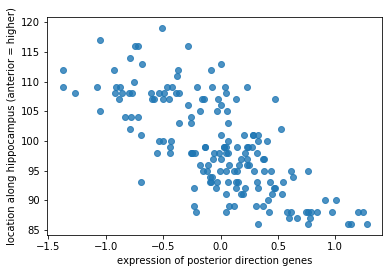

posterior 100 genes vs. y:  r2 = 0.5305694445470377, p = 2.167852996085666e-29 




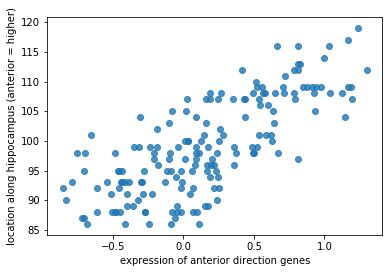

anterior 200 genes vs. y:  r2 = 0.5739899541952755, p = 6.005892221386507e-33 




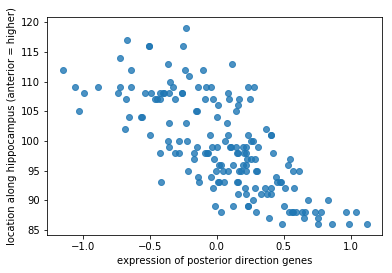

posterior 200 genes vs. y:  r2 = 0.5300127491687814, p = 2.3960150940034738e-29 




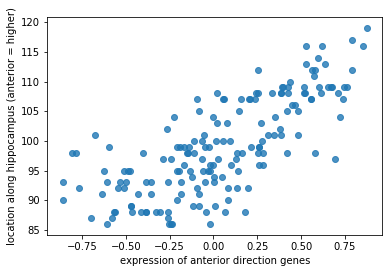

anterior 500 genes vs. y:  r2 = 0.561315373963959, p = 7.126299913099092e-32 




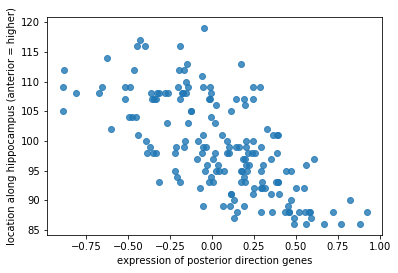

posterior 500 genes vs. y:  r2 = 0.4567010467132692, p = 5.001493967621759e-24 




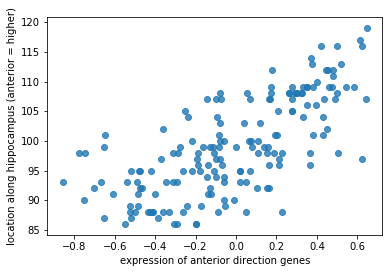

anterior 1000 genes vs. y:  r2 = 0.506219222540632, p = 1.5519698983995287e-27 




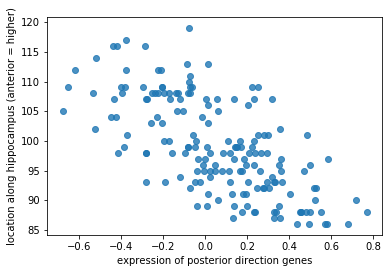

posterior 1000 genes vs. y:  r2 = 0.4544182935272975, p = 7.130482623735305e-24 




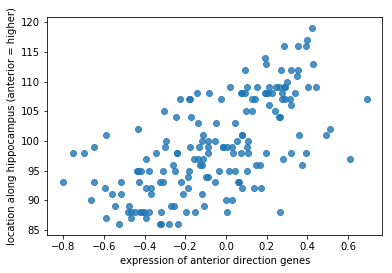

anterior 2000 genes vs. y:  r2 = 0.4135829007240299, p = 3.2074787398814058e-21 




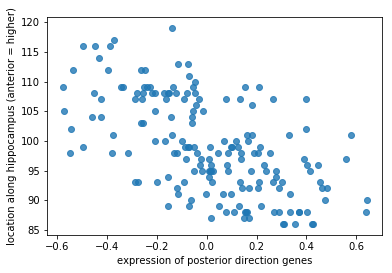

posterior 2000 genes vs. y:  r2 = 0.34865926180578455, p = 2.3587469013291807e-17 




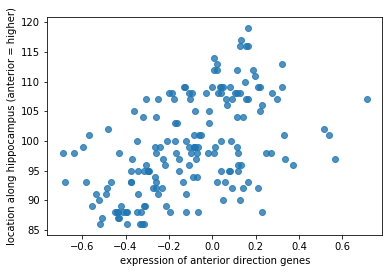

anterior 5000 genes vs. y:  r2 = 0.2602506835478756, p = 1.1941625384485097e-12 




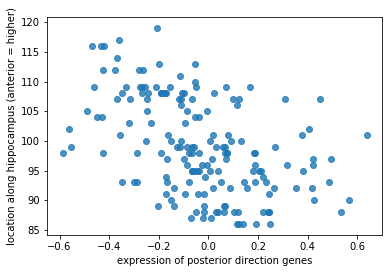

posterior 5000 genes vs. y:  r2 = 0.2270398562612534, p = 5.098941871190961e-11 




//anaconda/envs/py3/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


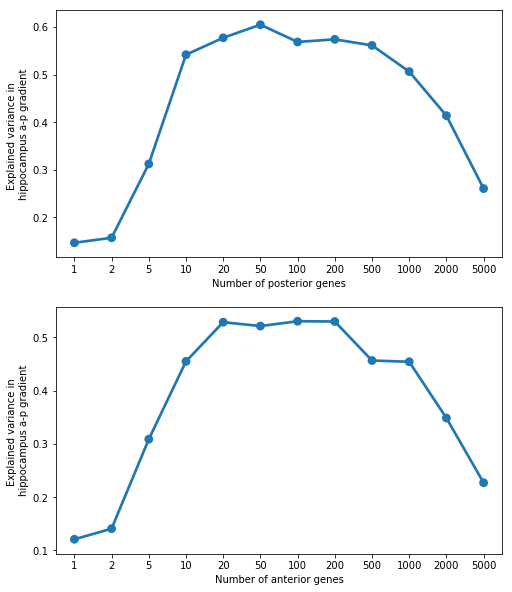

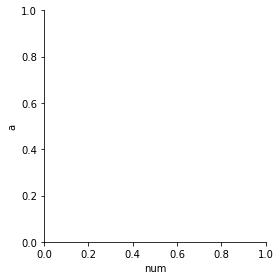

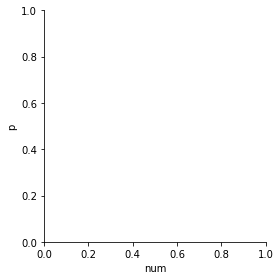

In [18]:
mod_HIPP = hap.PCA_LR_pipeline(xp.values.T, # X (Gene expression)
                                    df.position_along_hipp_AP_axis, # Y (Location on axis)
                                    cv_strategy='score', # Show the 10-fold CV score
                                    illustrative=True, # Show plots
                                    test_gene_num = [1, 2, 5, 10, 20, 50, 100,  # sanity check
                                                    200, 500, 1000, 2000, 5000],
                                    sanity_check_style = 'separate') # post. and ant. separate

In [19]:
big_hCM = pandas.read_csv('/Users/jakevogel/Science/AHBA/postreject/BIGDF_PCA_CompMtx.csv', 
                          index_col=0)
big_hCM.shape

(170, 58692)

In [22]:
hFunc_betas = np.dot(big_hCM.values.T, mod_hFUNC['betas'])

In [73]:
len(hFunc_betas)

58692

//anaconda/envs/py3/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


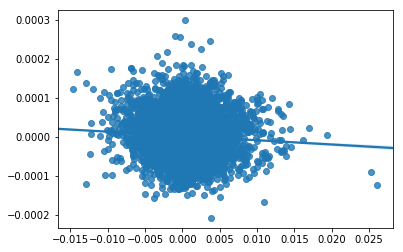

In [23]:
plt.close()
sns.regplot(mod_HIPP['betas'], hFunc_betas)
plt.show()

In [24]:
func_res = pandas.concat([pandas.Series(hFunc_betas),
                          probes.gene_symbol,
                         probes.gene_name], axis=1)
func_res.sort_values(0).head(50)

,0,gene_symbol,gene_name
18662,-0.000209,LRRC2,leucine rich repeat containing 2
24482,-0.000169,RSPO2,R-spondin 2
14562,-0.000157,EPN3,epsin 3
3000,-0.000155,IGFBP2,"insulin-like growth factor binding protein 2, ..."
31133,-0.000151,PKIG,"protein kinase (cAMP-dependent, catalytic) inh..."
25136,-0.000149,AC100803.1,FLJ43860 protein
8773,-0.000148,MAFB,v-maf musculoaponeurotic fibrosarcoma oncogene...
8774,-0.000147,MAFB,v-maf musculoaponeurotic fibrosarcoma oncogene...
13405,-0.000146,SOST,sclerostin
58065,-0.000144,A_24_P324424,AGILENT probe A_24_P324424 (non-RefSeq)


In [25]:
func_res.sort_values(0).tail(50)

,0,gene_symbol,gene_name
3105,0.000145,IL13RA2,"interleukin 13 receptor, alpha 2"
8682,0.000145,CARTPT,CART prepropeptide
43510,0.000145,DACH2,dachshund homolog 2 (Drosophila)
54894,0.000146,A_32_P332320,AGILENT probe A_32_P332320 (non-RefSeq)
21337,0.000147,C15orf27,chromosome 15 open reading frame 27
20951,0.000147,GOLT1A,golgi transport 1A
22218,0.000148,SAMD11,sterile alpha motif domain containing 11
7042,0.000148,TAF15,"TAF15 RNA polymerase II, TATA box binding prot..."
54760,0.000149,RBBP6,retinoblastoma binding protein 6
45594,0.000149,MCHR1,melanin-concentrating hormone receptor 1


In [26]:
func_res.sort_values(0, ascending=False, inplace=True)
func_res.loc[:,'A-P_order'] = range(len(func_res))
func_res.sort_values(0, ascending=True, inplace=True)
func_res.loc[:,'P-A_order'] = range(len(func_res))

In [27]:
hipp_res = pandas.concat([pandas.Series(mod_HIPP['betas']),
                          probes.gene_symbol,
                         probes.gene_name], axis=1)
hipp_res.sort_values(0).head()

,0,gene_symbol,gene_name
32889,-0.014675,NPNT,nephronectin
32888,-0.014107,NPNT,nephronectin
6582,-0.012919,TTR,transthyretin
51664,-0.012902,A_32_P11262,AGILENT probe A_32_P11262 (non-RefSeq)
44200,-0.012402,BDKRB1,bradykinin receptor B1


In [96]:
for probe in hipp_res.sort_values(0, ascending=False).index[:50]:
    PArank = func_res.loc[probe,'P-A_order']
    APrank = func_res.loc[probe,'A-P_order']
    if APrank < 500:
        print('ANTERIOR:', APrank, hipp_res.loc[probe,'gene_symbol'])
    if PArank < 500:
        print('POSTERIOR:', PArank, hipp_res.loc[probe,'gene_symbol'])

POSTERIOR: 29 SERPINF1
POSTERIOR: 204 SERPINF1
ANTERIOR: 324 OPRK1
POSTERIOR: 483 AQP3
POSTERIOR: 237 NR2F2
POSTERIOR: 1 RSPO2
ANTERIOR: 404 LGALS2


In [97]:
for probe in hipp_res.sort_values(0, ascending=True).index[:50]:
    PArank = func_res.loc[probe,'P-A_order']
    APrank = func_res.loc[probe,'A-P_order']
    if APrank < 500:
        print('ANTERIOR:', APrank, hipp_res.loc[probe,'gene_symbol'])
    if PArank < 500:
        print('POSTERIOR:', PArank, hipp_res.loc[probe,'gene_symbol'])

ANTERIOR: 116 NPNT
ANTERIOR: 22 NPNT
POSTERIOR: 37 TTR
ANTERIOR: 67 A_32_P11262
ANTERIOR: 114 HHIP
ANTERIOR: 308 HHIP
ANTERIOR: 159 BNC2
POSTERIOR: 139 TPBG
ANTERIOR: 225 RP11-291L15.2
ANTERIOR: 394 DDC
ANTERIOR: 17 A_24_P401842
POSTERIOR: 133 TNNT2
ANTERIOR: 191 CTXN3
ANTERIOR: 196 GAL
ANTERIOR: 175 GAL


In [122]:
n_phits = []
n_ahits = []
for i in range(1000):
    randind = np.random.choice(hipp_res.index, 50)
    ahits = []
    phits = []
    for probe in randind:
        PArank = func_res.loc[probe,'P-A_order']
        APrank = func_res.loc[probe,'A-P_order']
        if APrank < 500:
            ahits.append(probe)
        if PArank < 500:
            phits.append(probe)
    n_phits.append(len(phits))
    n_ahits.append(len(ahits))

In [123]:
n100_phits = []
n100_ahits = []
for i in range(1000):
    randind = np.random.choice(hipp_res.index, 50)
    ahits = []
    phits = []
    for probe in randind:
        PArank = func_res.loc[probe,'P-A_order']
        APrank = func_res.loc[probe,'A-P_order']
        if APrank < 100:
            ahits.append(probe)
        if PArank < 100:
            phits.append(probe)
    n100_phits.append(len(phits))
    n100_ahits.append(len(ahits))

In [130]:
jnk = np.array(n_phits)
1 - len(jnk[2>jnk]) / (1000+1) 

0.07692307692307687

In [137]:
jnk = np.array(n100_phits)
1 - len(jnk[0>jnk]) / (1000+1) 

1.0

In [138]:
len(jnk[jnk==0]) / 1000

0.919

#### Func results:
In the top 50 posterior genes:
    * 5 were found in the top 500 posterior func genes (p<0.001)
    * 2 were found in the top 100 posterior func genes (p<0.003)
    * However, 3 were found in the top 500 anterior func genes (p<0.006)
    * and 1 was found in the top 100 anterior func genes (p=0.08)
In the top 50 anterior genes:
    * 12 were found in the top 500 anterior func genes (p<0.001)
    * 2 were found in the top 100 anterior func genes (p=0.006)
    * However, 2 were found in the top 500 posterior func genes (p=0.07)
    * 0 were found in the top 100 posterior func genes (p=0.92)

## Repeat for mask3

In [20]:
msk1_2mm = image.resample_to_img(ni.Nifti1Image(msk3, ex.affine), 
                                 func, interpolation='nearest')

//anaconda/envs/py3/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


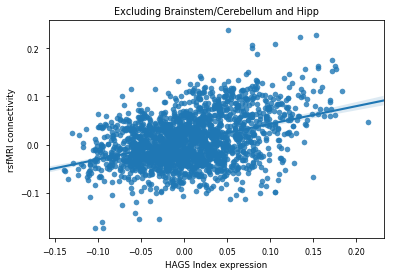

standard statistics: r2 = 0.15615709609475245, p = 3.188338992708105e-73


In [110]:
# functional
img = func.get_data()
vrad=3
vdim = 2
gcx_col='AP_axis_gxp_signature_similarity_SPCR'
bootstrap = False
plabs = ['Excluding Brainstem/Cerebellum and Hipp',
         'HAGS Index expression','rsfMRI connectivity']
res, vex = hap.run_gvfcx_analysis(img, gdf, msk1_2mm.get_data(), vrad, vdim, gcx_col, plabs, 
                       bootstrap, n_iter=10, hue_vals=[], illustrative=True)
vectors.update({'gcx': vex['g_vector'], 'fcx': vex['cx_vector']})

In [111]:
len(vectors['fcx'])

1932

In [113]:
# find samples falling within mask
gmsk = msk1_2mm.get_data()
gmsk[gmsk>0] = 1
hits = []
for i,row in gdf.iterrows():
    coords = hap.convert_coords([row['mni_nlin_x'], 
                                 row['mni_nlin_y'], 
                                 row['mni_nlin_z']], 
                                'xyz', vs=2)
    coords = tuple([int(round(x)) for x in coords])
    if gmsk[coords] == 1:
        hits.append(i)
    

In [114]:
len(hits)

1932

performing model cross-validation
using basic 10-fold cross-validation


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


model cv score: r2 =  0.26920432722173504
running final model
final model fit r2 =  0.3427158572362684
running sanity_check


//anaconda/envs/py3/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


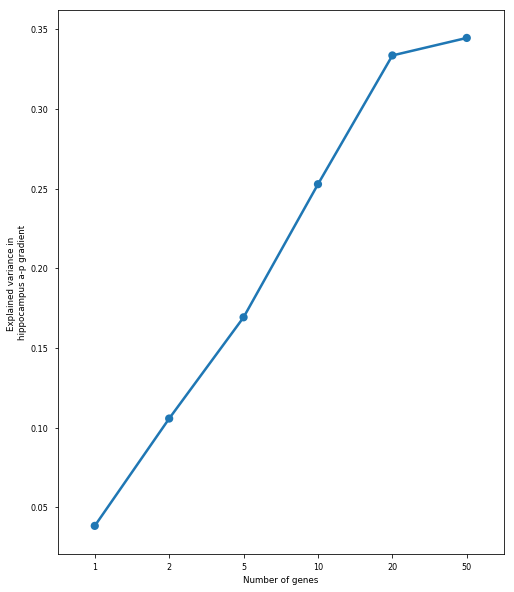

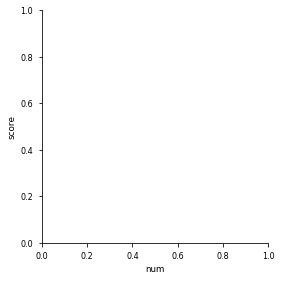

In [115]:
mod_hFUNC = hap.PCA_LR_pipeline(big_htfm.loc[hits].values, # X (Gene expression)
                                    vectors['fcx'], # Y (relative cx to a vs. p hipp)
                                    pca = None,
                                    cv_strategy='score', # Show the 10-fold CV score
                                    illustrative=False, # Don't show plots
                                    test_gene_num = [1, 2, 5, 10, 20, 50],
                                    sanity_check_style = 'model') # post. and ant. separate

In [192]:
hFunc_betas = np.dot(big_hCM.values.T, mod_hFUNC['betas'])

//anaconda/envs/py3/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


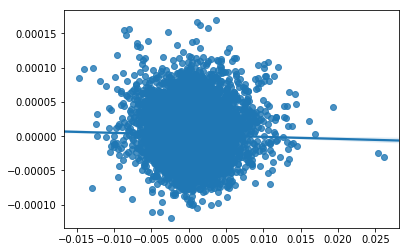

In [193]:
plt.close()
sns.regplot(mod_HIPP['betas'], hFunc_betas)
plt.show()

In [194]:
func_res = pandas.concat([pandas.Series(hFunc_betas),
                          probes.gene_symbol,
                         probes.gene_name], axis=1)

In [195]:
func_res.sort_values(0, ascending=False, inplace=True)
func_res.loc[:,'A-P_order'] = range(len(func_res))
func_res.sort_values(0, ascending=True, inplace=True)
func_res.loc[:,'P-A_order'] = range(len(func_res))

In [196]:
for probe in hipp_res.sort_values(0, ascending=False).index[:50]:
    PArank = func_res.loc[probe,'P-A_order']
    APrank = func_res.loc[probe,'A-P_order']
    if APrank < 500:
        print('ANTERIOR:', APrank, hipp_res.loc[probe,'gene_symbol'])
    if PArank < 500:
        print('POSTERIOR:', PArank, hipp_res.loc[probe,'gene_symbol'])

ANTERIOR: 469 SSTR1
ANTERIOR: 54 OPRK1
ANTERIOR: 112 GPR88
POSTERIOR: 407 NR2F2
POSTERIOR: 82 RSPO2
ANTERIOR: 181 LGALS2
POSTERIOR: 275 LXN
ANTERIOR: 40 A_32_P115840


In [197]:
for probe in hipp_res.sort_values(0, ascending=True).index[:50]:
    PArank = func_res.loc[probe,'P-A_order']
    APrank = func_res.loc[probe,'A-P_order']
    if APrank < 500:
        print('ANTERIOR:', APrank, hipp_res.loc[probe,'gene_symbol'])
    if PArank < 500:
        print('POSTERIOR:', PArank, hipp_res.loc[probe,'gene_symbol'])

ANTERIOR: 137 NPNT
ANTERIOR: 63 NPNT
POSTERIOR: 41 TTR
ANTERIOR: 60 A_32_P11262
ANTERIOR: 175 HHIP
ANTERIOR: 260 HHIP
ANTERIOR: 134 RP11-291L15.2
ANTERIOR: 334 DDC
ANTERIOR: 19 A_24_P401842
POSTERIOR: 183 TNNT2
ANTERIOR: 435 WNT10A
POSTERIOR: 34 PVALB
ANTERIOR: 87 CTXN3
ANTERIOR: 5 GAL
ANTERIOR: 7 GAL


In [177]:
n_phits = []
n_ahits = []
for i in range(1000):
    randind = np.random.choice(hipp_res.index, 50)
    ahits = []
    phits = []
    for probe in randind:
        PArank = func_res.loc[probe,'P-A_order']
        APrank = func_res.loc[probe,'A-P_order']
        if APrank < 500:
            ahits.append(probe)
        if PArank < 500:
            phits.append(probe)
    n_phits.append(len(phits))
    n_ahits.append(len(ahits))

In [178]:
n100_phits = []
n100_ahits = []
for i in range(1000):
    randind = np.random.choice(hipp_res.index, 50)
    ahits = []
    phits = []
    for probe in randind:
        PArank = func_res.loc[probe,'P-A_order']
        APrank = func_res.loc[probe,'A-P_order']
        if APrank < 100:
            ahits.append(probe)
        if PArank < 100:
            phits.append(probe)
    n100_phits.append(len(phits))
    n100_ahits.append(len(ahits))

In [164]:
jnk = np.array(n_ahits)
1 - len(jnk[3>jnk]) / (1000+1) 

0.006993006993006978

In [163]:
jnk = np.array(n100_ahits)
1 - len(jnk[2>jnk]) / (1000+1) 

0.004995004995005048

In [158]:
len(jnk[jnk==0]) / 1000

0.929

### Func results:

#### MASK 1
* First side Top500 AP Ratio: 5/2
* First side Top100 AP Ratio: 2/1
* Second side Top500 AP Ratio: 12/3
* Second side Top100 AP Ratio: 62

#### MASK 3
In the top 50 posterior genes:
    * 5 were found in the top 500 posterior func genes (p<0.001)
    * 0 were found in the top 100 posterior func genes (p=0.92)
    * However, 3 were found in the top 500 anterior func genes (p<0.007)
    * and 2 were found in the top 100 anterior func genes (p=0.005)
In the top 50 anterior genes:
    * 13 were found in the top 500 anterior func genes (p<0.001)
    * 5 were found in the top 100 anterior func genes (p<0.001)
    * However, 4 were found in the top 500 posterior func genes (p<0.001)
    * 1 was found in the top 100 posterior func genes (p=0.09)

#### MASK 4
THE RESULTS TOTALLY FLIPPED AND MADE ME QUESTION MY DIRECTIONS. 
WHAT I THOUGHT WAS POSTERIOR ENDED UP WITH AN 18/0 A/P RATIO
FOR TOP500 AND A 9/0 RATIO FOR TOP100. MEANWHILE, ON THE OTHER
SIDE, THE RATIOS WERE 6/5 and AND 2/4, RESPECTIVELY.


### Compare to PLS (mask 3)

In [21]:
from sklearn.cross_decomposition import PLSRegression, CCA, PLSCanonical
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_predict

ncs = 10
nc_chooser = pandas.DataFrame(index = range(ncs*3), columns = ['nc', 'estimator', 'r2','mae'])
i=0
for k,nc in enumerate(range(1,ncs+1)):
    print(nc)
    estimators = {'PLSR': PLSRegression(n_components=nc), 
                  'CCA': CCA(n_components=nc),
                 'PLSC': PLSCanonical(n_components=nc)}
    nc_chooser.loc[k*3:k*3+2,'nc'] = [nc]*3
    for lab, estimator in estimators.items():
        pred = cross_val_predict(estimator, big_tfm.loc[hits].values, vectors['fcx'], cv=10)
        nc_chooser.loc[i, 'r2'] = stats.pearsonr(vectors['fcx'], pred[:,0])[0]**2
        nc_chooser.loc[i, 'mae'] = mean_absolute_error(y_true=vectors['fcx'], y_pred=pred)
        nc_chooser.loc[i, 'estimator'] = lab
        i+=1

//anaconda/envs/py3/lib/python3.5/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


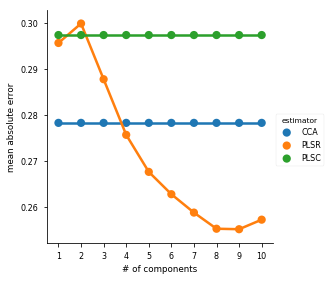

In [117]:
sns.factorplot(x = 'nc', y='r2', hue = 'estimator', data=nc_chooser)
plt.ylabel('mean absolute error')
plt.xlabel('# of components')
plt.show()

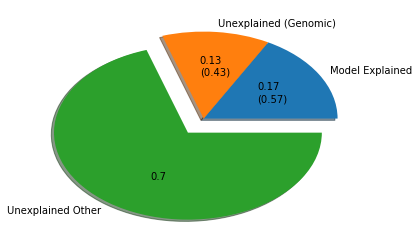

In [73]:
a = 0.17
b = 0.3 - a
c = 1 - (a+b)
xpl_var = [a,b,c]
labels = ['Model Explained','Unexplained (Genomic)', 'Unexplained Other']
plt.close()
plt.pie(xpl_var, labels=labels, shadow=True, explode=[0.0,0.0,0.2])
plt.text(0.4,0.2,'%s\n(%s)'%(round(a,2),
                             round((a/(a+b)),2)))
plt.text(-0.03,0.5,'%s\n(%s)'%(round(b,2),
                             round((b/(a+b)),2)))
plt.text(-0.4,-0.7,round(c,2))
plt.show()

In [31]:
plt.pie?

In [64]:
from importlib import reload
reload(cdj)

<module 'CrossDecomp' from '/Users/jakevogel/git/data_driven_pathology/CrossDecomp.py'>

finished iteration 0
finished iteration 100
finished iteration 200
finished iteration 300
finished iteration 400
finished iteration 500
finished iteration 600
finished iteration 700
finished iteration 800
finished iteration 900


//anaconda/envs/py3/lib/python3.5/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])
//anaconda/envs/py3/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


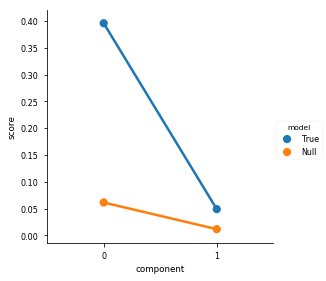

component 0: p = 0.001  ***
component 1: p = 0.001  ***


In [118]:
pls_mod = PLSRegression(n_components=2)
#pls_mod.fit(big_tfm.loc[hits].values, vectors['fcx'])
#sys.path.insert(0,'/home/users/jvogel/git/data_driven_pathology/')
sys.path.insert(0,'/Users/jakevogel/git/data_driven_pathology/')
import CrossDecomp as cdj

# significant components?
results, comp_sig = cdj.evaluate_components(pls_mod, big_tfm.loc[hits].values, 
                                            vectors['fcx'], n_iterations=1000)

In [22]:
pls_mod = PLSRegression(n_components=2)
pls_mod.fit(big_tfm.loc[hits].values,vectors['fcx'])

PLSRegression(copy=True, max_iter=500, n_components=2, scale=True, tol=1e-06)

//anaconda/envs/py3/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


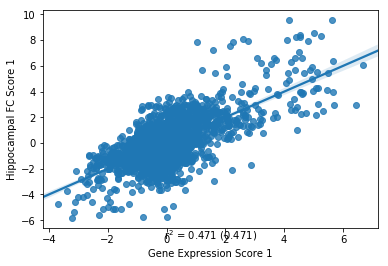

r2 = 0.4713533523322744, percent of total = 0.4713533523322744


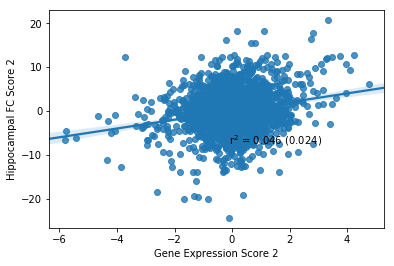

r2 = 0.04605676070740729, percent of total = 0.02434775215040549


In [23]:
# plot component scores
total = 1
leftover = 1
for i in range(pls_mod.n_components):
    r2 = stats.pearsonr(pls_mod.x_scores_[:,i], pls_mod.y_scores_[:,i])[0]**2
    explained = leftover * r2
    plt.close()
    sns.regplot(pls_mod.x_scores_[:,i], pls_mod.y_scores_[:,i])
    #plt.xlim(-3.5,3.5)
    #plt.ylim(-4,4)
    plt.xlabel('Gene Expression Score %i'%(i+1))
    plt.ylabel('Hippocampal FC Score %i'%(i+1))
    plt.text(-0.1,-7.5,'r$^2$ = %s (%s)'%(round(r2,3),round(explained,3)))
    #plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/principal_correlation_%s.pdf'%i,
    #           bbox_inches='tight')
    plt.show()
    print('r2 = %s, percent of total = %s'%(r2, explained))
    leftover = leftover - r2

In [123]:
pred[:,0].shape

(1932,)

//anaconda/envs/py3/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


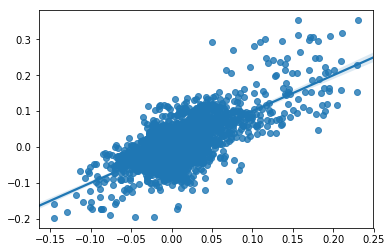

(0.7040604409300948, 1.12237e-318)
0.03570133997282383


In [24]:
pred = pls_mod.predict(big_tfm.loc[hits].values)
plt.close()
sns.regplot(pred[:,0], np.array(vectors['fcx']))
#plt.title(tr_y.columns[i])
plt.show()
print(stats.pearsonr(pred[:,0], vectors['fcx']))
print(mean_absolute_error(pred[:,0], vectors['fcx']))

//anaconda/envs/py3/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


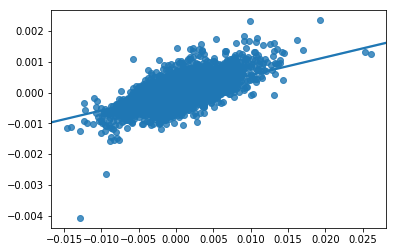

In [25]:
pls_betas = np.dot(big_hCM.values.T, pls_mod.coef_)
plt.close()
sns.regplot(mod_HIPP['betas'], pls_betas[:,0])
plt.show()

In [26]:
func_res = pandas.concat([pandas.Series(pls_betas[:,0]),
                          probes.gene_symbol,
                         probes.gene_name], axis=1)

In [27]:
func_res.sort_values(0, ascending=False, inplace=True)
func_res.loc[:,'A-P_order'] = range(len(func_res))
func_res.sort_values(0, ascending=True, inplace=True)
func_res.loc[:,'P-A_order'] = range(len(func_res))

In [216]:
fcx_ant = []
for probe in hipp_res.sort_values(0, ascending=False).index[:50]:
    PArank = func_res.loc[probe,'P-A_order']
    APrank = func_res.loc[probe,'A-P_order']
    if APrank < 50:
        print('ANTERIOR:', APrank, hipp_res.loc[probe,'gene_symbol'])
        fcx_ant.append(hipp_res.loc[probe,'gene_symbol'])
    if PArank < 50:
        print('POSTERIOR:', PArank, hipp_res.loc[probe,'gene_symbol'])

ANTERIOR: 2 KLK7
ANTERIOR: 22 KLK7
ANTERIOR: 24 PYDC1
ANTERIOR: 19 KCNG1
ANTERIOR: 40 C1orf187
ANTERIOR: 33 MYB
ANTERIOR: 14 C20orf103
ANTERIOR: 9 SYTL1


In [217]:
fcx_post = []
for probe in hipp_res.sort_values(0, ascending=True).index[:50]:
    PArank = func_res.loc[probe,'P-A_order']
    APrank = func_res.loc[probe,'A-P_order']
    if APrank < 50:
        print('ANTERIOR:', APrank, hipp_res.loc[probe,'gene_symbol'])
    if PArank < 50:
        print('POSTERIOR:', PArank, hipp_res.loc[probe,'gene_symbol'])
        fcx_post.append(hipp_res.loc[probe,'gene_symbol'])

POSTERIOR: 0 TTR
POSTERIOR: 7 ONECUT2
POSTERIOR: 3 TTR
POSTERIOR: 34 HPSE2
POSTERIOR: 5 PVALB
POSTERIOR: 1 CTXN3
POSTERIOR: 35 HPSE2
POSTERIOR: 15 GAL
POSTERIOR: 11 ONECUT2
POSTERIOR: 8 GAL


In [131]:
n100_phits = []
n100_ahits = []
for i in range(1000):
    randind = np.random.choice(hipp_res.index, 100)
    ahits = []
    phits = []
    for probe in randind:
        PArank = func_res.loc[probe,'P-A_order']
        APrank = func_res.loc[probe,'A-P_order']
        if APrank < 100:
            ahits.append(probe)
        if PArank < 100:
            phits.append(probe)
    n100_phits.append(len(phits))
    n100_ahits.append(len(ahits))

In [132]:
jnk = np.array(n100_ahits)
1 - len(jnk[17>jnk]) / (1000+1) 

0.0009990009990009652

### Let's have a look at SC instead...

//anaconda/envs/py3/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


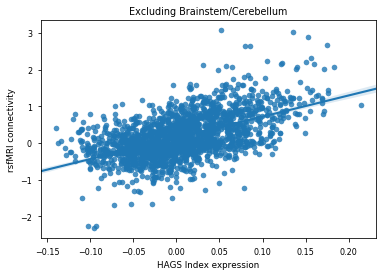

standard statistics: r2 = 0.2974205960720601, p = 3.827939448558621e-150


In [136]:
sc = ni.load('/Users/jakevogel/Science/AHBA/postreject/GA_struc_img.nii.gz')
img = sc.get_data()
vrad=3
vdim = 2
gcx_col='AP_axis_gxp_signature_similarity_SPCR'
bootstrap = False
plabs = ['Excluding Brainstem/Cerebellum',
         'HAGS Index expression','rsfMRI connectivity']
res, vex = hap.run_gvfcx_analysis(img, gdf, msk1_2mm.get_data(), vrad, vdim, gcx_col, plabs, 
                       bootstrap, n_iter=10, hue_vals=[], illustrative=True)
vectors.update({'gcx': vex['g_vector'], 'scx': vex['cx_vector']})



In [137]:
from sklearn.cross_decomposition import PLSRegression, CCA, PLSCanonical
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_predict

ncs = 10
nc_chooser = pandas.DataFrame(index = range(ncs*3), columns = ['nc', 'estimator', 'r2','mae'])
i=0
for k,nc in enumerate(range(1,ncs+1)):
    print(nc)
    estimators = {'PLSR': PLSRegression(n_components=nc), 
                  'CCA': CCA(n_components=nc),
                 'PLSC': PLSCanonical(n_components=nc)}
    nc_chooser.loc[k*3:k*3+2,'nc'] = [nc]*3
    for lab, estimator in estimators.items():
        pred = cross_val_predict(estimator, big_tfm.loc[hits].values, vectors['scx'], cv=10)
        nc_chooser.loc[i, 'r2'] = stats.pearsonr(vectors['scx'], pred[:,0])[0]**2
        nc_chooser.loc[i, 'mae'] = mean_absolute_error(y_true=vectors['scx'], y_pred=pred)
        nc_chooser.loc[i, 'estimator'] = lab
        i+=1

1
2


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/

3


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/

4


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/

5


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/

6


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/

7


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/

8


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/

9


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/

10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/

//anaconda/envs/py3/lib/python3.5/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


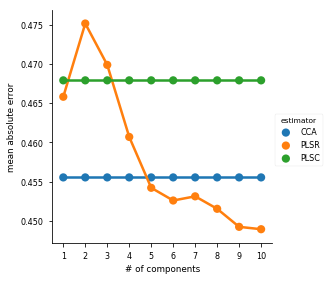

In [138]:
sns.factorplot(x = 'nc', y='r2', hue = 'estimator', data=nc_chooser)
plt.ylabel('mean absolute error')
plt.xlabel('# of components')
plt.show()

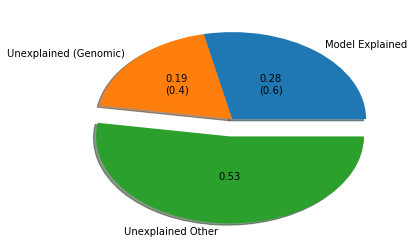

In [83]:
a = 0.284
b = 0.475 - a
c = 1 - (a+b)
xpl_var = [a,b,c]
labels = ['Model Explained','Unexplained (Genomic)', 'Unexplained Other']
plt.close()
plt.pie(xpl_var, labels=labels, shadow=True, explode=[0.0,0.0,0.2])
plt.text(0.2,0.3,'%s\n(%s)'%(round(a,2),
                             round((a/(a+b)),2)))
plt.text(-0.5,0.3,'%s\n(%s)'%(round(b,2),
                             round((b/(a+b)),2)))
plt.text(-0.1,-0.7,round(c,2))
plt.show()

finished iteration 0
finished iteration 100
finished iteration 200
finished iteration 300
finished iteration 400
finished iteration 500
finished iteration 600
finished iteration 700
finished iteration 800
finished iteration 900


//anaconda/envs/py3/lib/python3.5/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])
//anaconda/envs/py3/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


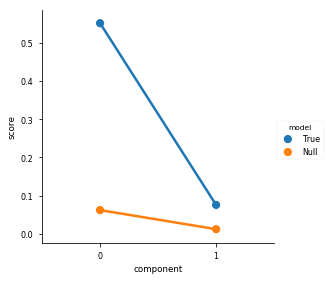

component 0: p = 0.001  ***
component 1: p = 0.001  ***


In [140]:
pls_mod = PLSRegression(n_components=2)
#pls_mod.fit(big_tfm.loc[hits].values, vectors['fcx'])
#sys.path.insert(0,'/home/users/jvogel/git/data_driven_pathology/')
sys.path.insert(0,'/Users/jakevogel/git/data_driven_pathology/')
import CrossDecomp as cdj

# significant components?
results, comp_sig = cdj.evaluate_components(pls_mod, big_tfm.loc[hits].values, 
                                            vectors['scx'], n_iterations=1000)

In [225]:
pls_mod = PLSRegression(n_components=2)
pls_mod.fit(big_tfm.loc[hits].values,vectors['scx'])

PLSRegression(copy=True, max_iter=500, n_components=2, scale=True, tol=1e-06)

//anaconda/envs/py3/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


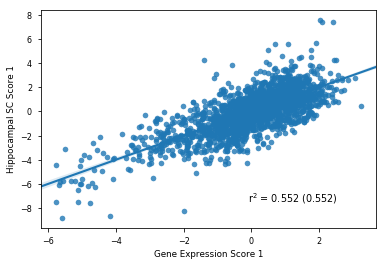

r2 = 0.5524099395619056, percent of total = 0.5524099395619056


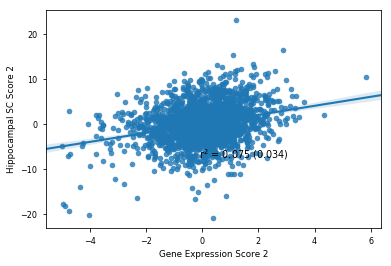

r2 = 0.07534534559992773, percent of total = 0.033723827790800756


In [142]:
# plot component scores
total = 1
leftover = 1
for i in range(pls_mod.n_components):
    r2 = stats.pearsonr(pls_mod.x_scores_[:,i], pls_mod.y_scores_[:,i])[0]**2
    explained = leftover * r2
    plt.close()
    sns.regplot(pls_mod.x_scores_[:,i], pls_mod.y_scores_[:,i])
    #plt.xlim(-3.5,3.5)
    #plt.ylim(-4,4)
    plt.xlabel('Gene Expression Score %i'%(i+1))
    plt.ylabel('Hippocampal SC Score %i'%(i+1))
    plt.text(-0.1,-7.5,'r$^2$ = %s (%s)'%(round(r2,3),round(explained,3)))
    #plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/principal_correlation_%s.pdf'%i,
    #           bbox_inches='tight')
    plt.show()
    print('r2 = %s, percent of total = %s'%(r2, explained))
    leftover = leftover - r2

//anaconda/envs/py3/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


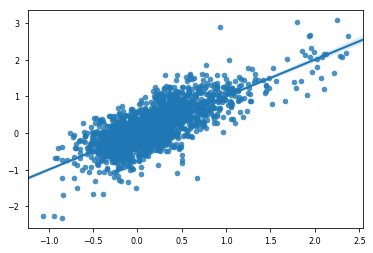

(0.7655937351838159, 0.0)
0.29596879992515573


In [144]:
pred = pls_mod.predict(big_tfm.loc[hits].values)
plt.close()
sns.regplot(pred[:,0], np.array(vectors['scx']))
#plt.title(tr_y.columns[i])
plt.show()
print(stats.pearsonr(pred[:,0], vectors['scx']))
print(mean_absolute_error(pred[:,0], vectors['scx']))

In [226]:
pls_betas = np.dot(big_hCM.values.T, pls_mod.coef_)
plt.close()
sns.regplot(mod_HIPP['betas'], pls_betas[:,0])
plt.show()

In [227]:
func_res = pandas.concat([pandas.Series(pls_betas[:,0]),
                          probes.gene_symbol,
                         probes.gene_name], axis=1)

In [228]:
func_res.sort_values(0, ascending=False, inplace=True)
func_res.loc[:,'A-P_order'] = range(len(func_res))
func_res.sort_values(0, ascending=True, inplace=True)
func_res.loc[:,'P-A_order'] = range(len(func_res))

In [229]:
scx_ant = []
for probe in hipp_res.sort_values(0, ascending=False).index[:50]:
    PArank = func_res.loc[probe,'P-A_order']
    APrank = func_res.loc[probe,'A-P_order']
    if APrank < 50:
        print('ANTERIOR:', APrank, hipp_res.loc[probe,'gene_symbol'])
        scx_ant.append(hipp_res.loc[probe,'gene_symbol'])
    if PArank < 50:
        print('POSTERIOR:', PArank, hipp_res.loc[probe,'gene_symbol'])

ANTERIOR: 13 KLK7
ANTERIOR: 43 RSPH9
ANTERIOR: 36 KLK7
ANTERIOR: 18 PYDC1
ANTERIOR: 16 TMEM215
ANTERIOR: 5 KCNG1
ANTERIOR: 30 C1orf187
ANTERIOR: 12 SYTL1
ANTERIOR: 20 A_32_P115840


In [230]:
scx_post = []
for probe in hipp_res.sort_values(0, ascending=True).index[:50]:
    PArank = func_res.loc[probe,'P-A_order']
    APrank = func_res.loc[probe,'A-P_order']
    if APrank < 50:
        print('ANTERIOR:', APrank, hipp_res.loc[probe,'gene_symbol'])
    if PArank < 50:
        print('POSTERIOR:', PArank, hipp_res.loc[probe,'gene_symbol'])
        scx_post.append(hipp_res.loc[probe,'gene_symbol'])

POSTERIOR: 0 TTR
POSTERIOR: 7 TPBG
POSTERIOR: 2 ONECUT2
POSTERIOR: 14 COL5A2
POSTERIOR: 31 TNNT2
POSTERIOR: 4 TTR
POSTERIOR: 15 COL5A2
POSTERIOR: 10 PVALB
POSTERIOR: 20 GAL
POSTERIOR: 34 COL5A2
POSTERIOR: 5 ONECUT2
POSTERIOR: 13 GAL


In [131]:
n100_phits = []
n100_ahits = []
for i in range(1000):
    randind = np.random.choice(hipp_res.index, 100)
    ahits = []
    phits = []
    for probe in randind:
        PArank = func_res.loc[probe,'P-A_order']
        APrank = func_res.loc[probe,'A-P_order']
        if APrank < 100:
            ahits.append(probe)
        if PArank < 100:
            phits.append(probe)
    n100_phits.append(len(phits))
    n100_ahits.append(len(ahits))

In [132]:
jnk = np.array(n100_ahits)
1 - len(jnk[17>jnk]) / (1000+1) 

0.0009990009990009652

### AND DISEASE

//anaconda/envs/py3/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


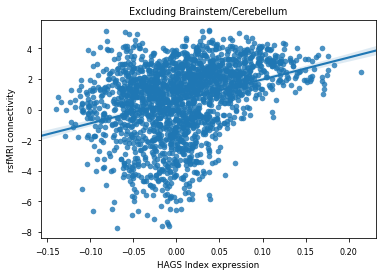

standard statistics: r2 = 0.1125009274963534, p = 5.173715983417446e-52


In [150]:
dis = ni.load('/Users/jakevogel/Science/AHBA/postreject/GA_dis_img.nii.gz')
img = dis.get_data()
vrad=3
vdim = 2
gcx_col='AP_axis_gxp_signature_similarity_SPCR'
bootstrap = False
plabs = ['Excluding Brainstem/Cerebellum',
         'HAGS Index expression','rsfMRI connectivity']
res, vex = hap.run_gvfcx_analysis(img, gdf, msk1_2mm.get_data(), vrad, vdim, gcx_col, plabs, 
                       bootstrap, n_iter=10, hue_vals=[], illustrative=True)
vectors.update({'gcx': vex['g_vector'], 'dis': vex['cx_vector']})




In [151]:
from sklearn.cross_decomposition import PLSRegression, CCA, PLSCanonical
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_predict

ncs = 10
nc_chooser = pandas.DataFrame(index = range(ncs*3), columns = ['nc', 'estimator', 'r2','mae'])
i=0
for k,nc in enumerate(range(1,ncs+1)):
    print(nc)
    estimators = {'PLSR': PLSRegression(n_components=nc), 
                  'CCA': CCA(n_components=nc),
                 'PLSC': PLSCanonical(n_components=nc)}
    nc_chooser.loc[k*3:k*3+2,'nc'] = [nc]*3
    for lab, estimator in estimators.items():
        pred = cross_val_predict(estimator, big_tfm.loc[hits].values, vectors['dis'], cv=10)
        nc_chooser.loc[i, 'r2'] = stats.pearsonr(vectors['dis'], pred[:,0])[0]**2
        nc_chooser.loc[i, 'mae'] = mean_absolute_error(y_true=vectors['dis'], y_pred=pred)
        nc_chooser.loc[i, 'estimator'] = lab
        i+=1

1
2


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/

3


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/

4


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/

5


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/

6


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/

7


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/

8


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/

9


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/

10


//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/lib/python3.5/site-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)
//anaconda/envs/py3/

//anaconda/envs/py3/lib/python3.5/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


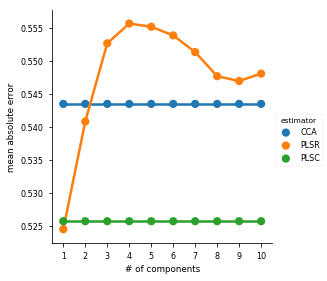

In [152]:
sns.factorplot(x = 'nc', y='r2', hue = 'estimator', data=nc_chooser)
plt.ylabel('mean absolute error')
plt.xlabel('# of components')
plt.show()

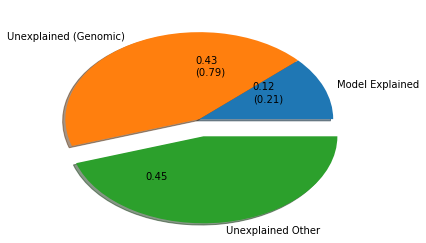

In [84]:
a = 0.118
b = 0.55 - a
c = 1 - (a+b)
xpl_var = [a,b,c]
labels = ['Model Explained','Unexplained (Genomic)', 'Unexplained Other']
plt.close()
plt.pie(xpl_var, labels=labels, shadow=True, explode=[0.0,0.0,0.2])
plt.text(0.4,0.2,'%s\n(%s)'%(round(a,2),
                             round((a/(a+b)),2)))
plt.text(-0.03,0.5,'%s\n(%s)'%(round(b,2),
                             round((b/(a+b)),2)))
plt.text(-0.4,-0.7,round(c,2))
plt.show()

finished iteration 0
finished iteration 100
finished iteration 200
finished iteration 300
finished iteration 400
finished iteration 500
finished iteration 600
finished iteration 700
finished iteration 800
finished iteration 900


//anaconda/envs/py3/lib/python3.5/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])
//anaconda/envs/py3/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


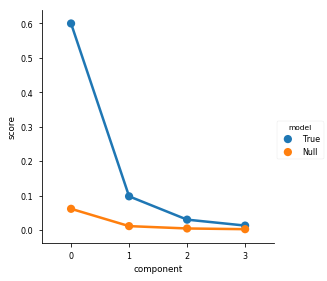

component 0: p = 0.001  ***
component 1: p = 0.001  ***
component 2: p = 0.001  ***
component 3: p = 0.001  ***


In [153]:
pls_mod = PLSRegression(n_components=4)
#pls_mod.fit(big_tfm.loc[hits].values, vectors['fcx'])
#sys.path.insert(0,'/home/users/jvogel/git/data_driven_pathology/')

# significant components?
results, comp_sig = cdj.evaluate_components(pls_mod, big_tfm.loc[hits].values, 
                                            vectors['dis'], n_iterations=1000)

In [218]:
pls_mod = PLSRegression(n_components=4)
pls_mod.fit(big_tfm.loc[hits].values,vectors['dis'])

PLSRegression(copy=True, max_iter=500, n_components=4, scale=True, tol=1e-06)

//anaconda/envs/py3/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


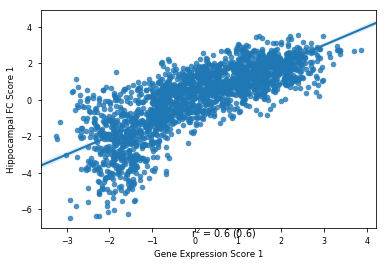

r2 = 0.5999252987408619, percent of total = 0.5999252987408619


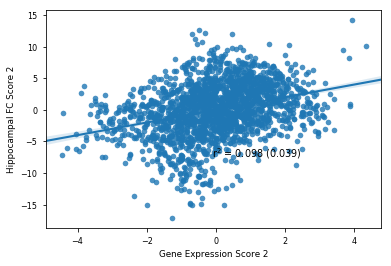

r2 = 0.09823863203069619, percent of total = 0.03930279136178717


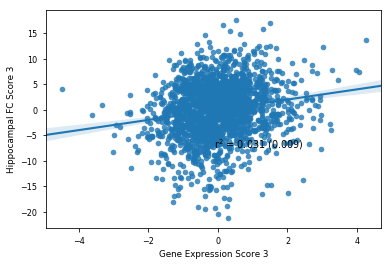

r2 = 0.030582002233513154, percent of total = 0.009230751343299043


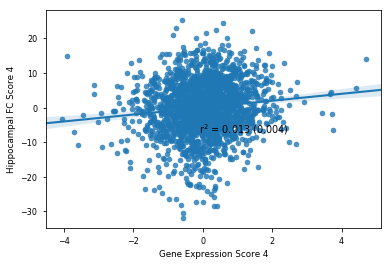

r2 = 0.013352529525540517, percent of total = 0.0036219279384727327


In [155]:
# plot component scores
total = 1
leftover = 1
for i in range(pls_mod.n_components):
    r2 = stats.pearsonr(pls_mod.x_scores_[:,i], pls_mod.y_scores_[:,i])[0]**2
    explained = leftover * r2
    plt.close()
    sns.regplot(pls_mod.x_scores_[:,i], pls_mod.y_scores_[:,i])
    #plt.xlim(-3.5,3.5)
    #plt.ylim(-4,4)
    plt.xlabel('Gene Expression Score %i'%(i+1))
    plt.ylabel('Hippocampal FC Score %i'%(i+1))
    plt.text(-0.1,-7.5,'r$^2$ = %s (%s)'%(round(r2,3),round(explained,3)))
    #plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/NEUR608/principal_correlation_%s.pdf'%i,
    #           bbox_inches='tight')
    plt.show()
    print('r2 = %s, percent of total = %s'%(r2, explained))
    leftover = leftover - r2

//anaconda/envs/py3/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


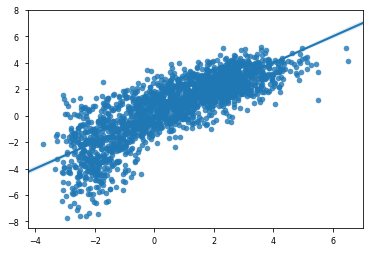

(0.8092781574422457, 0.0)
1.110763362777494


In [158]:
pred = pls_mod.predict(big_tfm.loc[hits].values)
plt.close()
sns.regplot(pred[:,0], np.array(vectors['dis']))
#plt.title(tr_y.columns[i])
plt.show()
print(stats.pearsonr(pred[:,0], vectors['dis']))
print(mean_absolute_error(pred[:,0], vectors['dis']))

In [219]:
pls_betas = np.dot(big_hCM.values.T, pls_mod.coef_)
plt.close()
sns.regplot(mod_HIPP['betas'], pls_betas[:,0])
plt.show()

In [220]:
func_res = pandas.concat([pandas.Series(pls_betas[:,0]),
                          probes.gene_symbol,
                         probes.gene_name], axis=1)

In [221]:
func_res.sort_values(0, ascending=False, inplace=True)
func_res.loc[:,'A-P_order'] = range(len(func_res))
func_res.sort_values(0, ascending=True, inplace=True)
func_res.loc[:,'P-A_order'] = range(len(func_res))

In [223]:
dis_ant = []
for probe in hipp_res.sort_values(0, ascending=False).index[:50]:
    PArank = func_res.loc[probe,'P-A_order']
    APrank = func_res.loc[probe,'A-P_order']
    if APrank < 50:
        print('ANTERIOR:', APrank, hipp_res.loc[probe,'gene_symbol'])
        dis_ant.append(hipp_res.loc[probe,'gene_symbol'])
    if PArank < 50:
        print('POSTERIOR:', PArank, hipp_res.loc[probe,'gene_symbol'])

POSTERIOR: 24 C1QL1
ANTERIOR: 7 PIRT
ANTERIOR: 25 OPRK1
ANTERIOR: 6 LGALS2
ANTERIOR: 4 A_32_P115840


In [224]:
dis_post = []
for probe in hipp_res.sort_values(0, ascending=True).index[:50]:
    PArank = func_res.loc[probe,'P-A_order']
    APrank = func_res.loc[probe,'A-P_order']
    if APrank < 50:
        print('ANTERIOR:', APrank, hipp_res.loc[probe,'gene_symbol'])
    if PArank < 50:
        print('POSTERIOR:', PArank, hipp_res.loc[probe,'gene_symbol'])
        dis_post.append(hipp_res.loc[probe,'gene_symbol'])

ANTERIOR: 13 TTR
POSTERIOR: 25 COL5A2
POSTERIOR: 21 COL5A2
POSTERIOR: 43 PVALB


In [187]:
n100_phits = []
n100_ahits = []
for i in range(1000):
    randind = np.random.choice(hipp_res.index, 50)
    ahits = []
    phits = []
    for probe in randind:
        PArank = func_res.loc[probe,'P-A_order']
        APrank = func_res.loc[probe,'A-P_order']
        if APrank < 100:
            ahits.append(probe)
        if PArank < 100:
            phits.append(probe)
    n100_phits.append(len(phits))
    n100_ahits.append(len(ahits))

In [191]:
jnk = np.array(n100_ahits)
1 - len(jnk[1>jnk]) / (1000+1) 

0.06693306693306689

In [192]:
jnk = np.array(n100_phits)
1 - len(jnk[1>jnk]) / (1000+1) 

0.08991008991008986

In [194]:
#func_res

### Summarize with Venn Diagrams

In [195]:
import matplotlib_venn_wordcloud

In [313]:
fake = ['COL5A2', 'PVALB',' ']

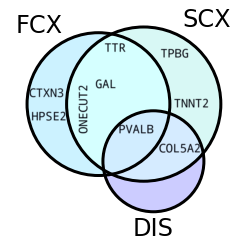

In [316]:
plt.close()
matplotlib_venn_wordcloud.venn3_wordcloud([set(fcx_post), set(scx_post),set(fake)],
                                         set_labels = ('FCX','SCX','DIS'),
                                         set_colors =['deepskyblue','turquoise','b'],
                                         alpha=0.2)
plt.savefig('/Users/jakevogel/Dropbox/Work/Projects/AHBA_Hippocampus_AP/P_Venn.pdf',
           bbox_inches = 'tight')
plt.show()


In [308]:
scx_ant.remove('A_32_P115840')
scx_ant.append('GABRQ')

dis_ant.remove('A_32_P115840')
dis_ant.append('GABRQ')

In [309]:
fake_dis = dis_ant + [' ']

In [305]:
fake_fcx = fcx_ant + [' ']

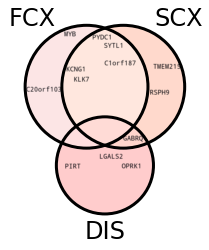

In [318]:
plt.close()
matplotlib_venn_wordcloud.venn3_wordcloud([set(fake_fcx), set(scx_ant),set(fake_dis)],
                                         set_labels = ('FCX','SCX','DIS'),
                                         set_colors =['lightcoral','orangered','r'],
                                         alpha=0.2)
plt.savefig('/Users/jakevogel/Dropbox/Work/Projects/AHBA_Hippocampus_AP/A_Venn.pdf',
           bbox_inches = 'tight')
plt.show()

In [319]:
scx_ant

['KLK7',
 'RSPH9',
 'KLK7',
 'PYDC1',
 'TMEM215',
 'KCNG1',
 'C1orf187',
 'SYTL1',
 'GABRQ']